In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
#from xgboost.sklearn import XGBRegressor

import statsmodels.tsa.api as smt

import pickle

In [2]:
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [3]:
import math
from sklearn import preprocessing, svm

In [5]:
series = pd.read_excel('junfu_1C.xlsx')
data = series

In [198]:
n_test = 10

In [7]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    #second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    #second.date = pd.to_datetime(second.date, format='%Y')
    #sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Minute",
           ylabel = "Capacity",
           title = title)
    
    sns.despine()

In [6]:
data['capacity_diff'] = data['Capacity'].diff()
data = data.dropna()

In [9]:
dt_data = data.set_index('Cycle').drop('Capacity', axis=1)
dt_data.dropna(axis=0)
    
smt.stattools.adfuller(dt_data['capacity_diff'], regression = 'ct')

(-7758610029.687829,
 0.0,
 5,
 593,
 {'1%': -3.974118095774561,
  '5%': -3.417919623619064,
  '10%': -3.131421471382838},
 -34899.22246698216)

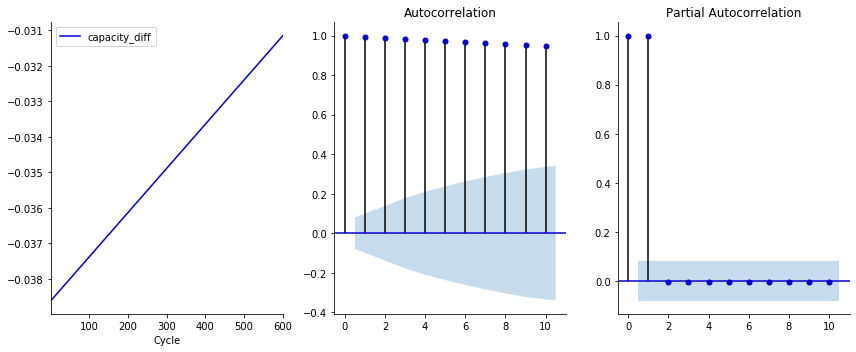

In [11]:
def plots(data, lags=None):
    
    # Convert dataframe to datetime index
    dt_data = data.set_index('Cycle').drop('Capacity', axis=1)
    dt_data.dropna(axis=0)
    
    smt.stattools.adfuller(dt_data['capacity_diff'], regression = 'c')
    
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    dt_data.plot(ax=raw, figsize=(12, 5), color='mediumblue')
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    sns.despine()
    plt.tight_layout()

plots(data, lags=10);

In [13]:
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,6):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['capacity_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    #supervised_df.to_csv('../data/model_df.csv', index=False)
    
    return supervised_df

In [14]:
model_df = generate_supervised(data)

In [15]:
model_df.head()

,Cycle,Capacity,capacity_diff,lag_1,lag_2,lag_3,lag_4,lag_5
0,7,99.768517,-0.038549,-0.038562,-0.038574,-0.038587,-0.038599,-0.038612
1,8,99.729980,-0.038537,-0.038549,-0.038562,-0.038574,-0.038587,-0.038599
2,9,99.691456,-0.038524,-0.038537,-0.038549,-0.038562,-0.038574,-0.038587
3,10,99.652944,-0.038512,-0.038524,-0.038537,-0.038549,-0.038562,-0.038574
4,11,99.614444,-0.038499,-0.038512,-0.038524,-0.038537,-0.038549,-0.038562


In [20]:
model_df = model_df.drop(['Cycle'],axis=1)
forecast_col = 'Capacity'
forecast_out = int(math.ceil(0.1 * len(model_df)))
model_df['label'] = model_df[forecast_col].shift(-forecast_out)

In [21]:
model_df

,Capacity,capacity_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,label
0,99.940333,0.020179,-0.001111,0.001362,-0.006170,-0.032670,0.006286,0.042492,-0.039598,0.031982,...,-0.067421,0.114575,0.018928,0.040154,0.002298,7.190660e-02,-1.660762e-01,-1.110320e-02,4.712479e-01,99.838584
1,99.941681,0.001348,0.020179,-0.001111,0.001362,-0.006170,-0.032670,0.006286,0.042492,-0.039598,...,-0.008561,-0.067421,0.114575,0.018928,0.040154,2.298077e-03,7.190660e-02,-1.660762e-01,-1.110320e-02,99.835294
2,99.958467,0.016786,0.001348,0.020179,-0.001111,0.001362,-0.006170,-0.032670,0.006286,0.042492,...,0.004737,-0.008561,-0.067421,0.114575,0.018928,4.015364e-02,2.298077e-03,7.190660e-02,-1.660762e-01,99.835463
3,99.957695,-0.000772,0.016786,0.001348,0.020179,-0.001111,0.001362,-0.006170,-0.032670,0.006286,...,0.033383,0.004737,-0.008561,-0.067421,0.114575,1.892792e-02,4.015364e-02,2.298077e-03,7.190660e-02,99.835465
4,99.963061,0.005366,-0.000772,0.016786,0.001348,0.020179,-0.001111,0.001362,-0.006170,-0.032670,...,-0.043009,0.033383,0.004737,-0.008561,-0.067421,1.145748e-01,1.892792e-02,4.015364e-02,2.298077e-03,99.835922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4135,97.904518,-0.000491,-0.000306,-0.000007,-0.001309,-0.000626,-0.001097,-0.000024,-0.000253,-0.000546,...,-0.000077,-0.000209,-0.000483,-0.001557,-0.000456,8.739701e-07,-4.397289e-04,-2.594772e-05,-3.082481e-04,NaN
4136,97.904528,0.000010,-0.000491,-0.000306,-0.000007,-0.001309,-0.000626,-0.001097,-0.000024,-0.000253,...,-0.000008,-0.000077,-0.000209,-0.000483,-0.001557,-4.557186e-04,8.739701e-07,-4.397289e-04,-2.594772e-05,NaN
4137,97.904199,-0.000329,0.000010,-0.000491,-0.000306,-0.000007,-0.001309,-0.000626,-0.001097,-0.000024,...,-0.001059,-0.000008,-0.000077,-0.000209,-0.000483,-1.557004e-03,-4.557186e-04,8.739701e-07,-4.397289e-04,NaN
4138,97.904138,-0.000061,-0.000329,0.000010,-0.000491,-0.000306,-0.000007,-0.001309,-0.000626,-0.001097,...,-0.000928,-0.001059,-0.000008,-0.000077,-0.000209,-4.830164e-04,-1.557004e-03,-4.557186e-04,8.739701e-07,NaN


In [23]:
model_df = model_df[['label','Capacity',
 'capacity_diff',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11']]

In [24]:
model_df

,label,Capacity,capacity_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
0,99.838584,99.940333,0.020179,-0.001111,0.001362,-0.006170,-0.032670,0.006286,0.042492,-0.039598,0.031982,-0.001867,0.000511,0.038873
1,99.835294,99.941681,0.001348,0.020179,-0.001111,0.001362,-0.006170,-0.032670,0.006286,0.042492,-0.039598,0.031982,-0.001867,0.000511
2,99.835463,99.958467,0.016786,0.001348,0.020179,-0.001111,0.001362,-0.006170,-0.032670,0.006286,0.042492,-0.039598,0.031982,-0.001867
3,99.835465,99.957695,-0.000772,0.016786,0.001348,0.020179,-0.001111,0.001362,-0.006170,-0.032670,0.006286,0.042492,-0.039598,0.031982
4,99.835922,99.963061,0.005366,-0.000772,0.016786,0.001348,0.020179,-0.001111,0.001362,-0.006170,-0.032670,0.006286,0.042492,-0.039598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4135,NaN,97.904518,-0.000491,-0.000306,-0.000007,-0.001309,-0.000626,-0.001097,-0.000024,-0.000253,-0.000546,-0.000068,-0.000974,-0.001584
4136,NaN,97.904528,0.000010,-0.000491,-0.000306,-0.000007,-0.001309,-0.000626,-0.001097,-0.000024,-0.000253,-0.000546,-0.000068,-0.000974
4137,NaN,97.904199,-0.000329,0.000010,-0.000491,-0.000306,-0.000007,-0.001309,-0.000626,-0.001097,-0.000024,-0.000253,-0.000546,-0.000068
4138,NaN,97.904138,-0.000061,-0.000329,0.000010,-0.000491,-0.000306,-0.000007,-0.001309,-0.000626,-0.001097,-0.000024,-0.000253,-0.000546


In [25]:
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

In [26]:
train_set, test_set = train_test_split(model_df, forecast_out);

In [27]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.values.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.values.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train_set, test_set)

In [28]:
y_test

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [ ]:
# ---=== D E F I N E   S E M U A   F U N G S I ===---

In [30]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_excel('Kapasitas Setelah 30 Cycle Skenario 2.xlsx')
    #original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    #original_df = original_df.groupby('date')['sales'].sum().reset_index()
    #original_df.date = pd.to_datetime(original_df.date)
    
    return original_df


In [31]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=True):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [32]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-forecast_out:]['Minute'])
    act_sales = list(original_df[-forecast_out:]['Capacity'])
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0])
        result_dict['date'] = sales_dates[index]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [33]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name, forecast_out):
    rmse = np.sqrt(mean_squared_error(original_df['Capacity'][-forecast_out:], unscaled_df.pred_value[-forecast_out:]))
    mae = mean_absolute_error(original_df['Capacity'][-forecast_out:], unscaled_df.pred_value[-forecast_out:])
    r2 = r2_score(original_df['Capacity'][-forecast_out:], unscaled_df.pred_value[-forecast_out:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [34]:
def combine_data(original_df, unscaled_df):
    alldata = pd.concat([original_df['Capacity'], unscaled_df['pred_value']], ignore_index=True)
    minute = pd.DataFrame(np.arange(len(alldata)), columns = ['Minute'])
    alldata = pd.DataFrame(alldata, columns = ['Capacity'])
    alldata['Minute'] = minute
    
    return alldata

In [35]:
def plot_results(alldata, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(alldata['Minute'][:-forecast_out], alldata['Capacity'][:-forecast_out], data=alldata, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(alldata['Minute'][-forecast_out:], alldata['Capacity'][-forecast_out:], data=alldata, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Minute",
           ylabel = "Capacity",
           title = f"{model_name} Capacity Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
    #plt.savefig(f'../model_output/{model_name}_forecast.png')

In [ ]:
# ---=== B U A T   M O D E L   N E U R A L   N E T W O R K ===---

In [36]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [37]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
            stateful=True))
model.add(Dense(1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [38]:
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, 
            shuffle=False)

Train on 3726 samples
Epoch 1/100
3726/3726 [==============================] - 13s 3ms/sample - loss: 0.0192
Epoch 2/100
3726/3726 [==============================] - 8s 2ms/sample - loss: 0.0117
Epoch 3/100
3726/3726 [==============================] - 8s 2ms/sample - loss: 0.0025
Epoch 4/100
3726/3726 [==============================] - 8s 2ms/sample - loss: 0.0015
Epoch 5/100
3726/3726 [==============================] - 8s 2ms/sample - loss: 9.7721e-04
Epoch 6/100
3726/3726 [==============================] - 8s 2ms/sample - loss: 7.3694e-04
Epoch 7/100
3726/3726 [==============================] - 9s 2ms/sample - loss: 5.5452e-04
Epoch 8/100
3726/3726 [==============================] - 9s 2ms/sample - loss: 3.9909e-04
Epoch 9/100
3726/3726 [==============================] - 8s 2ms/sample - loss: 2.9396e-04
Epoch 10/100
3726/3726 [==============================] - 9s 2ms/sample - loss: 2.8286e-04
Epoch 11/100
3726/3726 [==============================] - 9s 2ms/sample - loss: 2.3983e-04
E

In [39]:
predictions = model.predict(X_test,batch_size=1)

In [ ]:
# ---=== C O M P I L E   S E M U A   F U N G S I ===---

In [40]:
original_df = load_original_df()

In [41]:
unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)

In [42]:
unscaled_df = predict_df(unscaled, original_df)

In [43]:
get_scores(unscaled_df, original_df, "LSTM", forecast_out)

RMSE: 1.006649884924447
MAE: 1.0048580038577057
R2 Score: -280.1421590070407


In [44]:
alldata = combine_data(original_df, unscaled_df)

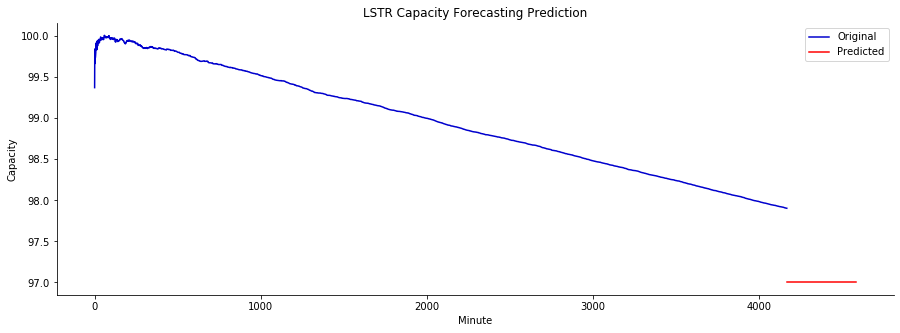

In [45]:
plot_results(alldata, 'LSTR')